In [64]:
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
from colorit import *
init_colorit()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
 


# Part 1: Data Inspection

In [65]:
coint_prices = pd.read_csv('data.csv',index_col = 'Date')
coint_prices.head(10)

,BABA,FB
Date,,
2018-01-02,183.649994,181.419998
2018-01-03,184.000000,184.669998
2018-01-04,185.710007,184.330002
2018-01-05,190.699997,186.850006
2018-01-08,190.330002,188.279999
2018-01-09,190.800003,187.869995
2018-01-10,189.789993,187.839996
2018-01-11,188.750000,187.770004
2018-01-12,187.789993,179.369995


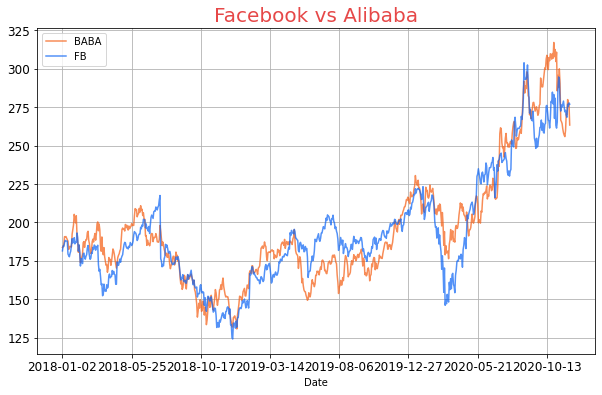

In [66]:
coint_prices.plot(figsize = (10,6), 
                  fontsize = 12,
                 color = ['#F55C10','#0A63F5'],alpha = 0.7)
plt.title('Facebook vs Alibaba',
          fontsize = 20,
         color = '#E64848')
plt.grid(True)

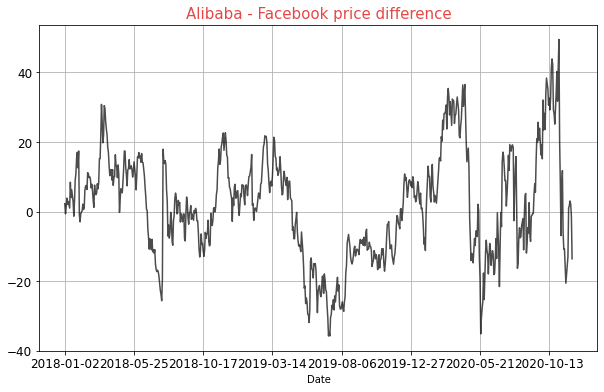

In [67]:
prices_diff = coint_prices.BABA - coint_prices.FB
prices_diff.plot(figsize = (10,6), 
                  fontsize = 12,
                color = 'black',
                alpha = 0.7)
plt.title('Alibaba - Facebook price difference',
          fontsize = 15,
         color = '#E64848')
plt.grid(True)

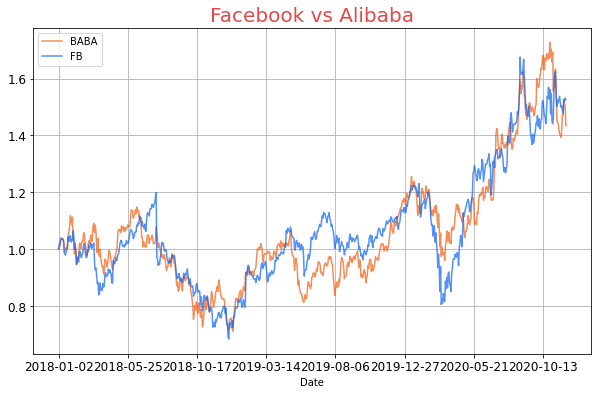

In [68]:
coint_prices = coint_prices/coint_prices.iloc[0]
coint_prices.plot(figsize = (10,6), 
                  fontsize = 12,
                 color = ['#F55C10','#0A63F5'],
                  alpha = 0.7)
plt.title('Facebook vs Alibaba',fontsize = 20,color = '#E64848')
plt.grid(True)

In [69]:
# return

In [70]:
returns = np.log(coint_prices).diff().dropna()
returns.head()

,BABA,FB
Date,,
2018-01-03,0.001904,0.017756
2018-01-04,0.009251,-0.001843
2018-01-05,0.026515,0.013579
2018-01-08,-0.001942,0.007624
2018-01-09,0.002466,-0.002180


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4c4883c70>,
      dtype=object)

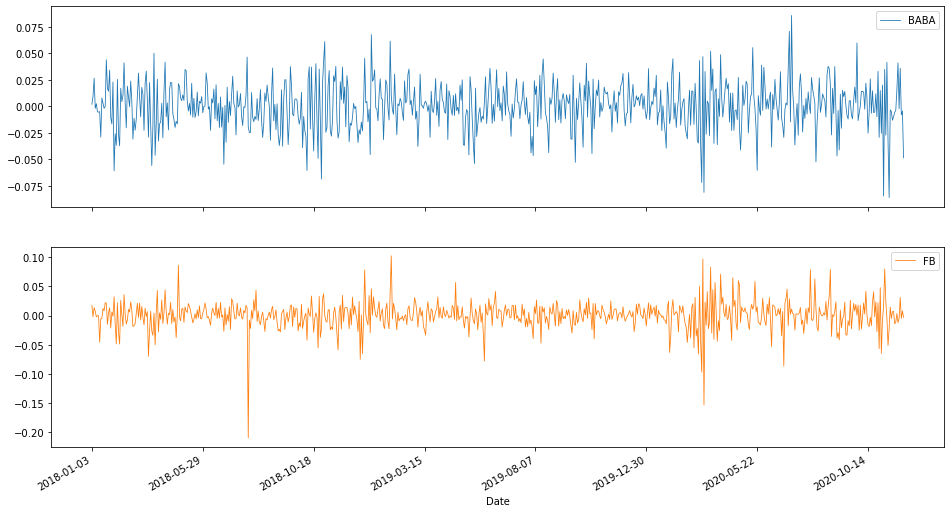

In [71]:
returns.plot(figsize = (16,9),subplots = True, linewidth = 0.8)

In [72]:
returns

,BABA,FB
Date,,
2018-01-03,0.001904,0.017756
2018-01-04,0.009251,-0.001843
2018-01-05,0.026515,0.013579
2018-01-08,-0.001942,0.007624
2018-01-09,0.002466,-0.002180
...,...,...
2020-11-23,-0.002330,-0.004720
2020-11-24,0.035817,0.031139
2020-11-25,-0.008033,-0.004814


In [73]:
from utility import VAR

In [74]:
model = VAR(returns, lag = 1)
model.report()

Estimate Coefficient           SD of Estimate            \
                              BABA        FB           BABA        FB   
(Lag_1, BABA)             0.045013 -0.030688       0.043083  0.047057   
(Lag_1, FB)              -0.073990 -0.099768       0.039143  0.042752   
constant                  0.000510  0.000652       0.000821  0.000897   

              t-Statistic            
                     BABA        FB  
(Lag_1, BABA)    1.044792 -0.652155  
(Lag_1, FB)     -1.890267 -2.333627  
constant         0.620490  0.727090

In [75]:
model.p_value < 0.05

,BABA,FB
"(Lag_1, BABA)",False,False
"(Lag_1, FB)",False,True
constant,False,False


In [76]:
model.IC(lag = 10,)

,AIC,BIC
Lag,,
1,-15.339415,-15.301785
2,-15.332764,-15.270047
3,-15.331255,-15.243451
4,-15.321393,-15.208503
5,-15.312210,-15.174233
6,-15.308782,-15.145718
7,-15.306070,-15.117920
8,-15.309380,-15.096142
9,-15.303473,-15.065149


In [77]:
model.stability()

Stability status: [o] STABLE


# Part 2: Cointegration

In [78]:
coint_prices = pd.read_csv('data.csv',index_col = 'Date')
FB = pd.DataFrame(coint_prices['FB'])
BABA = pd.DataFrame(coint_prices['BABA'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4c96adc10>,
      dtype=object)

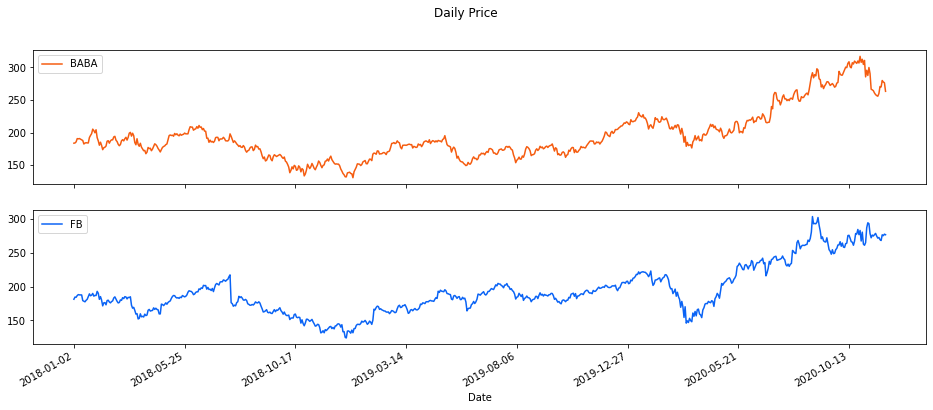

In [79]:
coint_prices.plot( figsize = (16,6),
                  color = ['#F55C10','#0A63F5'],
                  subplots = True,
                 title = 'Daily Price',)

# Engle Granger step 1  FB - BABA

In [80]:
from utility import LinearRegression as LR

In [81]:
model = LR(x = BABA, y = FB) 
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,FB,FB,FB
BABA,0.864299,0.013810,62.585632
constant,24.744947,2.749676,8.999223


In [82]:
#b_coint, constant
model.coef

,FB
BABA,0.864299
constant,24.744947


In [84]:
residuals = pd.DataFrame(model.error.reshape(1,len(FB))[0],
                         index = BABA.index,
                         columns = ['Residual(FB - β·BABA)'])
residuals.head()

,Residual(FB - β·BABA)
Date,
2018-01-02,-2.053493
2018-01-03,0.893997
2018-01-04,-0.923957
2018-01-05,-2.716797
2018-01-08,-0.967018


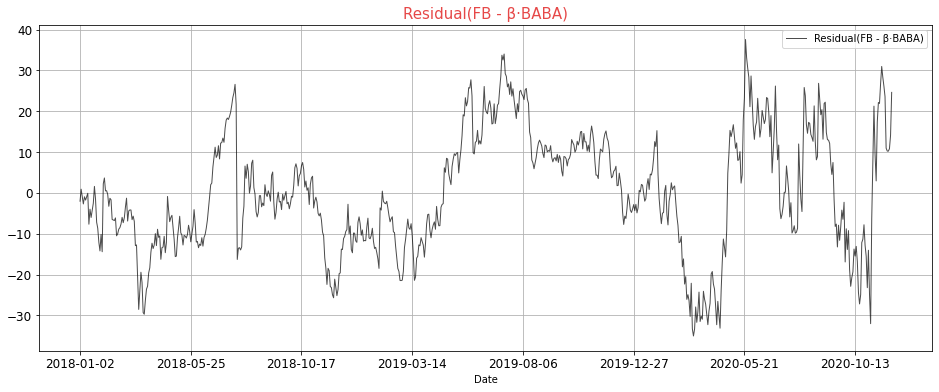

In [85]:
residuals.plot(figsize = (16,6),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.title('Residual(FB - β·BABA)',
         color = '#E64848',
         fontsize = 15)
plt.grid(True)

In [86]:
from utility import ADF

In [87]:
adf_test = ADF(residuals)
adf_test.report()

The T-value is [-4.15444074] which is lower than -3.45
[*]We reject the  𝐻0  hypothesis of unit root. The residuals are stationary.


,Estimate Coefficient,SD of Estimate,t-Statistic
,(ΔResidual(FB - β·BABA)),(ΔResidual(FB - β·BABA)),(ΔResidual(FB - β·BABA))
"(Lag 1, Residual(FB - β·BABA))",-0.047907,0.011532,-4.154441
"(Lag 1, ΔResidual(FB - β·BABA))",0.030824,0.037194,0.828745
constant,0.030233,0.164179,0.184150


# Engle Granger step 2 FB - BABA


$$ {  ΔPA_{𝑡}=𝜑ΔPB_{𝑡} − (1−𝛼)𝑒ˆ𝑡−1+𝜀_{𝑡} }$$

$$ { ΔFB𝑡 = 𝜑ΔBABA_{𝑡} −(1−𝛼)CointResidual(FB \; on \; BABA_{𝑡−1}) + 𝜀_{t} }$$

In [88]:
Δy = pd.DataFrame(FB).diff().dropna().add_prefix('Δ')
Δx = pd.DataFrame(BABA).diff().dropna().add_prefix('Δ')

X = Δx.join(residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')'))

model = LR(X, Δy,add_const = False)
model.report()


,Estimate Coefficient,SD of Estimate,t-Statistic
,ΔFB,ΔFB,ΔFB
ΔBABA,0.510556,0.034257,14.903664
"(Lag 1, Residual(FB - β·BABA))",-0.040760,0.010647,-3.828437


In [89]:
model.p_value < 0.05

,ΔFB
ΔBABA,True
"(Lag 1, Residual(FB - β·BABA))",True


# Engle Granger step 1 BABA - FB

In [194]:
model = LR(x = FB, y = BABA,add_const = False) 
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,BABA,BABA,BABA
FB,1.007933,0.002882,349.707391


In [195]:
residuals = pd.DataFrame(model.error.reshape(1,len(BABA))[0],
                         index = BABA.index,
                         columns = ['Residual(BABA - β·FB)'])
residuals.head()

,Residual(BABA - β·FB)
Date,
2018-01-02,0.790822
2018-01-03,-2.134954
2018-01-04,-0.082253
2018-01-05,2.367742
2018-01-08,0.556410


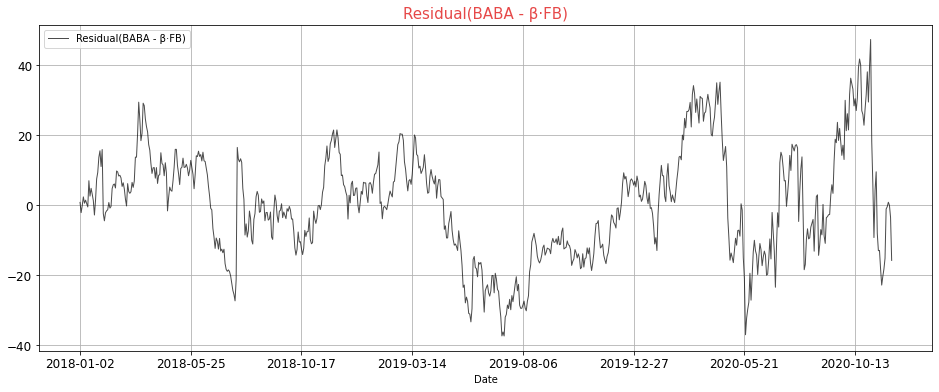

In [196]:
residuals.plot(figsize = (16,6),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.title('Residual(BABA - β·FB)',
          color = '#E64848',
         fontsize = 15)
plt.grid(True)

In [197]:
adf_test = ADF(residuals)
adf_test.report()

The T-value is [-4.28850575] which is lower than -3.45
[*]We reject the  𝐻0  hypothesis of unit root. The residuals are stationary.


,Estimate Coefficient,SD of Estimate,t-Statistic
,(ΔResidual(BABA - β·FB)),(ΔResidual(BABA - β·FB)),(ΔResidual(BABA - β·FB))
"(Lag 1, Residual(BABA - β·FB))",-0.049132,0.011457,-4.288506
"(Lag 1, ΔResidual(BABA - β·FB))",0.041300,0.037176,1.110932
constant,-0.006292,0.174084,-0.036141


In [198]:
model = VAR(residuals, lag = 1)
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,Residual(BABA - β·FB),Residual(BABA - β·FB),Residual(BABA - β·FB)
"(Lag_1, Residual(BABA - β·FB))",0.952820,0.011309,84.252206
constant,-0.009857,0.173683,-0.056752


In [203]:
B = model.coef.values[0][0]
C = model.coef.values[1][0]
mu = C/(1-B)
mu

-0.20892017490430786

In [200]:
tau = 1/252

In [201]:
SSE = np.sum(model.error**2)
sigma_eq = ((SSE*tau/(1-B**2))**0.5).values[0]
sigma_eq

26.417774961521552

Text(0.5, 1.0, 'Signals (Z = 0.5)')

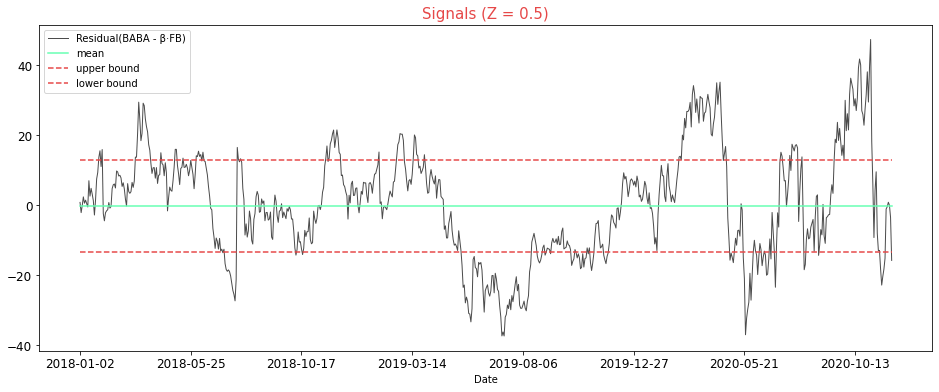

In [204]:
Z = 0.5
residuals.plot(figsize = (16,6),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.plot(np.ones(len(residuals))*mu,
        color = '#66ffb3', label = 'mean')

plt.plot(np.ones(len(residuals))*(mu+Z*sigma_eq),
         '--', color = '#E64848', label = 'upper bound')
plt.plot(np.ones(len(residuals))*(mu-Z*sigma_eq),
         '--',color = '#E64848', label = 'lower bound')
plt.legend(fontsize = 10)

plt.title('Signals (Z = {})'.format(Z),
          color = '#E64848',
         fontsize = 15)
